In [1]:
try: 
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2
%run basic_material

from casadi import *
from pylab import plot, step, figure, legend, show, spy

opts0 = {"ipopt.linear_solver":'ma27', "ipopt.tol":1e-3, "expand":False,'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}

Running Python: 3.8.12


In [55]:
N = 240 # number of control intervals
opti = Opti() # Optimization problem
Tf = 5
t = np.linspace(0, Tf, N)

R0 = 1  # initial radius
Mu = 1  # orbit param
m0 = 1  # initial fuel
m1 = -0.07485 # fuel descrease rate
print(f'Initial Mass = {m0 :0.3f}')
print(f'Final Mass = {m0 + m1*Tf:0.3f}')
T = 0.1405    # thrust

Initial Mass = 1.000
Final Mass = 0.626


In [56]:
# ---- decision variables ---------
X = opti.variable(3,N+1) # state trajectory
orbit_r = X[0,:]
orbit_u = X[1,:]
orbit_v = X[2,:]
U = opti.variable(1,N)   # control trajectory (throttle)

opti.minimize(-orbit_r[-1]) # race in minimal time

# dx/dt = f(x,u)
f = lambda x,u,t: vertcat(x[1],
  x[2]**2/x[0] - Mu/x[0]**2 + T*sin(u)/(m0 + m1*t),
 -x[1]*x[2]/x[0] + T*cos(u)/(m0 + m1*t)) 

dt = Tf/N # length of a control interval
for k in range(N-1): # loop over control intervals
    k1 = f(X[:,k],         U[:,k],k*dt)
    k2 = f(X[:,k]+dt/2*k1, (U[:,k]+U[:,k+1])/2.0,(k+1/2)*dt)
    k3 = f(X[:,k]+dt/2*k2, (U[:,k]+U[:,k+1])/2.0,(k+1/2)*dt)
    k4 = f(X[:,k]+dt*k3,   U[:,k+1],(k+1)*dt)
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
    opti.subject_to(X[:,k+1]==x_next) # close the gaps
else:
    # now do the last step (no u(k+1))
    k = N-1
    k1 = f(X[:,k],         U[:,k],k*dt)
    k2 = f(X[:,k]+dt/2*k1, U[:,k],(k+1/2)*dt)
    k3 = f(X[:,k]+dt/2*k2, U[:,k],(k+1/2)*dt)
    k4 = f(X[:,k]+dt*k3,   U[:,k],(k+1)*dt)
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
    opti.subject_to(X[:,k+1]==x_next) # close the gaps

opti.subject_to(opti.bounded(-np.pi,U,np.pi)) # control is limited

# ---- boundary conditions --------
opti.subject_to(orbit_r[0] == R0)   # start at position 0 ...
opti.subject_to(orbit_u[0] == 0) # ... from stand-still 
opti.subject_to(orbit_v[0] == np.sqrt(Mu/R0)) # ... from stand-still 
opti.subject_to(orbit_u[-1] == 0) # ... from stand-still 
opti.subject_to(orbit_v[-1] == np.sqrt(Mu/orbit_r[-1])) # ... from stand-still 

# ---- misc. constraints  ----------
opti.subject_to(orbit_r >= R0) # Time must be positive

# ---- initial values for solver ---
opti.set_initial(orbit_r, R0)
opti.set_initial(orbit_u, 0)
opti.set_initial(orbit_v, np.sqrt(Mu/R0))

opts = {"ipopt.linear_solver":'ma27', "ipopt.tol":1e-3, "expand":False, 
        'ipopt.print_level': 1, 'print_time': 0, 'ipopt.sb': 'yes'}
opti.solver('ipopt',opts) # set numerical backend

sol = opti.solve()   # actual solve
sol.value

         but the previous value is set to disallow clobbering.
         The setting will remain as: "linear_solver ma27"
         but the previous value is set to disallow clobbering.
         The setting will remain as: "tol 0.001"


<bound method OptiSol.value of OptiSol(Opti {
  instance #10
  #variables: 2 (nx = 963)
  #parameters: 0 (np = 0)
  #constraints: 247 (ng = 1206)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})>

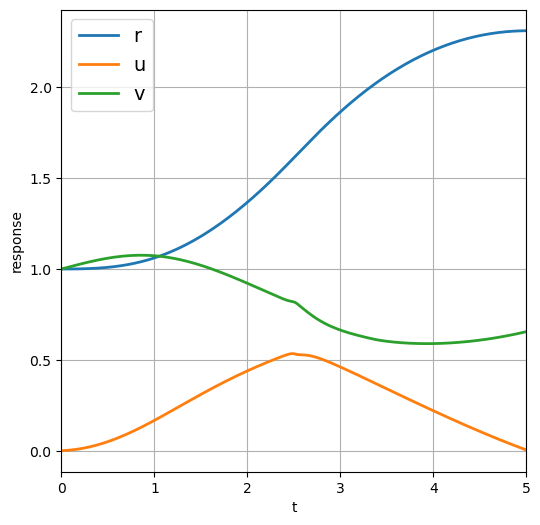

In [57]:
plt.figure(figsize = (6,6))
plt.plot(t,sol.value(orbit_r)[:-1],label="r")
plt.plot(t,sol.value(orbit_u)[:-1],label="u")
plt.plot(t,sol.value(orbit_v)[:-1],label="v")
plt.legend(loc="upper left")
plt.xlabel('t')
plt.ylabel('response')
plt.legend()
plt.legend(fontsize=14)
plt.xlim([0,Tf])
plt.savefig("figs/Orbit_casadi_1.png")
plt.show()

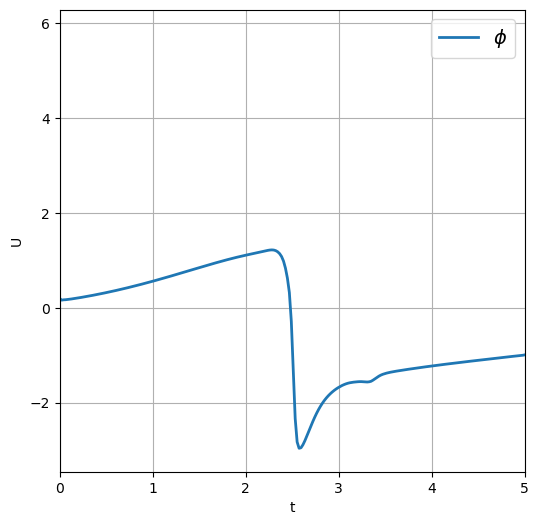

In [58]:
phi = sol.value(U)
phi = (phi + np.pi) % (2 * np.pi) - np.pi #https://stackoverflow.com/questions/15927755/opposite-of-numpy-unwrap/15927914

plt.figure(figsize = (6,6))
plt.plot(t,phi,label="$\phi$")
plt.legend(loc="upper left")
plt.xlabel('t')
plt.ylabel('U')
plt.legend()
plt.legend(fontsize=14)
plt.xlim([0,Tf])
plt.ylim([-1.1*np.pi,2*np.pi])
plt.savefig("figs/Orbit_casadi_2.png")
plt.show()